# Multi Resolution Simulation

### Classes and modules

In [2]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
import datetime
from IPython.display import display
import copy

#For plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# plt.rcParams["lines.color"] = "w"
# plt.rcParams["text.color"] = "w"
# plt.rcParams["axes.labelcolor"] = "w"
# plt.rcParams["xtick.color"] = "w"
# plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"

GPU Ocean-modules:

In [3]:
from gpuocean.utils import IPythonMagic, Common, WindStress
from gpuocean.SWEsimulators import CDKLM16

In [4]:
%cuda_context_handler gpu_ctx

Rossby utils

In [5]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))
from utils.RossbyInit import *
from utils.WindPerturb import *

In [6]:
wind_N = 100
t_splits = 26

In [7]:
KLSampler = KarhunenLoeve_Sampler(t_splits, wind_N)
wind_weight = wind_bump(KLSampler.N,KLSampler.N)

## Data Assimilation

In [8]:
def imshow3(etahuhv):
    fig, axs = plt.subplots(1,3, figsize=(15,10))
    im = axs[0].imshow(etahuhv[0], vmin=-0.05, vmax=0.05, cmap="coolwarm")
    plt.colorbar(im, ax=axs[0], shrink=0.5)
    axs[0].set_title("$\eta$", fontsize=15)

    im = axs[1].imshow(etahuhv[1], vmin=-1, vmax=1, cmap="coolwarm")
    plt.colorbar(im, ax=axs[1], shrink=0.5)
    axs[1].set_title("$hu$", fontsize=15)

    im = axs[2].imshow(etahuhv[2], vmin=-1, vmax=1, cmap="coolwarm")
    plt.colorbar(im, ax=axs[2], shrink=0.5)
    axs[2].set_title("$hv$", fontsize=15)

    return fig, axs

In [9]:
ls = [6, 7, 8, 9, 10]
T = 250000

### Truth

In [10]:
data_args = initLevel(ls[-1])
true_wind = wind_sample(KLSampler, wind_weight=wind_weight)
truth = CDKLM16.CDKLM16(gpu_ctx, **data_args, wind=true_wind)
truth.step(T)

250000.0

In [11]:
true_eta, true_hu, true_hv = truth.download(interior_domain_only=True)

In [12]:
Hfield = np.zeros((truth.ny,truth.nx))
Hy, Hx = 800, 600
Hfield[Hy,Hx] = 1.0

R = [0.0001, 0.01, 0.01]

obs = [true_eta[Hy,Hx], true_hu[Hy,Hx], true_hv[Hy,Hx]] + np.random.normal(0,R)

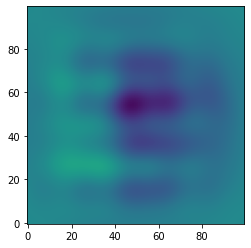

In [13]:
plt.imshow(true_wind.wind_u[25], vmin=-5,vmax=5)

Text(0.5, 0.85, 'Truth')

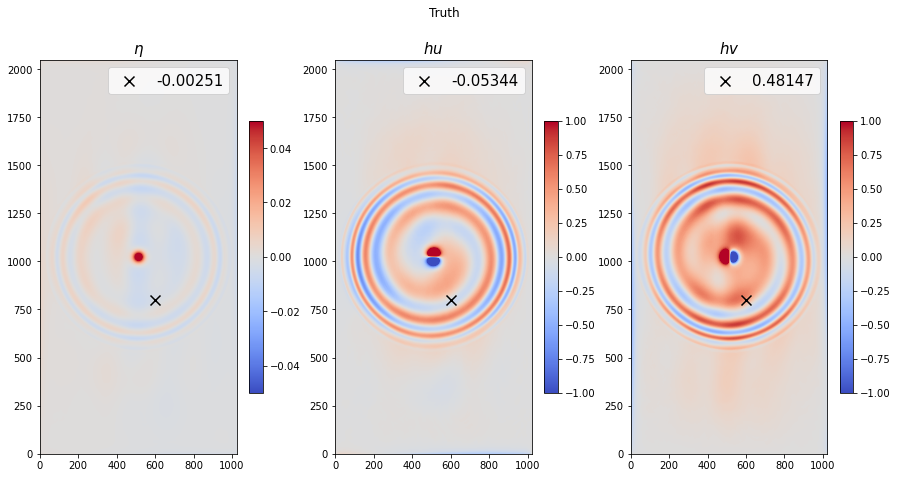

In [14]:
fig, axs = imshow3([true_eta, true_hu, true_hv])
axs[0].scatter(Hx,Hy, marker="x", c="black", label=str(round(obs[0],5)), s=100)
axs[0].legend(labelcolor="black", fontsize=15)
axs[1].scatter(Hx, Hy, marker="x", c="black", label=str(round(obs[1],5)), s=100)
axs[1].legend(labelcolor="black", fontsize=15)
axs[2].scatter(Hx, Hy, marker="x", c="black", label=str(round(obs[2],5)), s=100)
axs[2].legend(labelcolor="black", fontsize=15)
fig.suptitle("Truth", y=0.85)


### Ensemble sizes 

In [15]:
vars_file = "../scripts/OutputVarianceLevels/Rossby-vars-NEWwind.npy"
diff_vars_file = "../scripts/OutputVarianceLevels/Rossby-diff_vars-NEWwind.npy"

In [16]:
from utils.RossbyAnalysis import *

In [17]:
rossbyAnalysis = RossbyAnalysis(ls, vars_file, diff_vars_file)

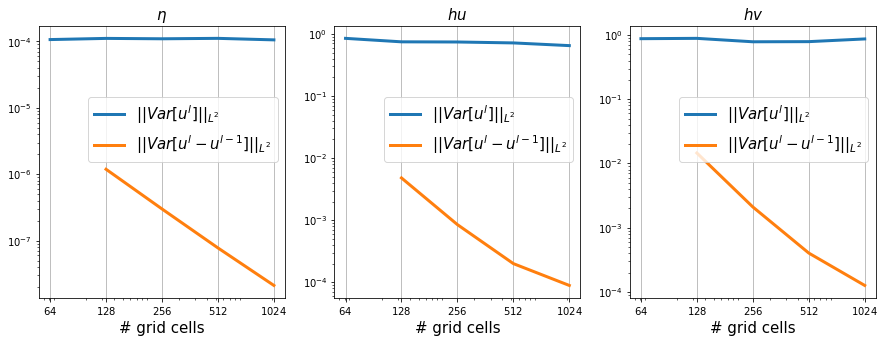

In [18]:
rossbyAnalysis.plotLvlVar()

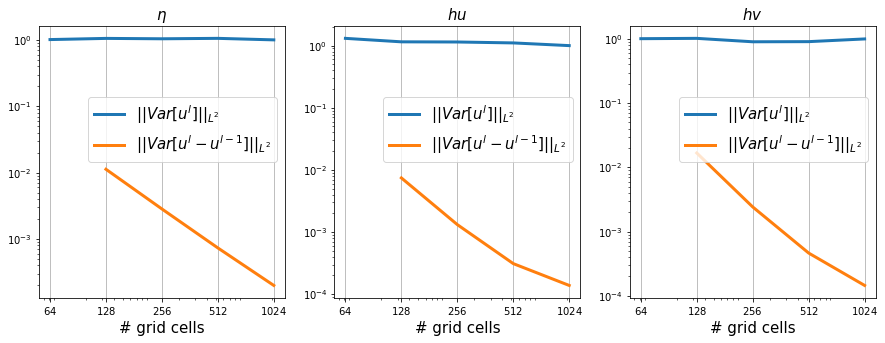

In [19]:
rossbyAnalysis.plotLvlVar(relative=True)

In [20]:
Nes = rossbyAnalysis.optimal_Ne(tau=1.5*1e-7)
Nes

array([3014,  156,   34,    9,    3], dtype=int32)

In [21]:
SL_Ne = int(round(rossbyAnalysis.work(Nes)/rossbyAnalysis._level_work(ls[-1])))
SL_Ne

6

### One-level Ensemble

In [22]:
STOPP

Exception caught: Resetting to CUDA context gpu_ctx
Traceback (most recent call last):
  File "/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3552, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_1655037/2904576707.py", line 1, in <module>
    STOPP
NameError: name 'STOPP' is not defined


NameError: name 'STOPP' is not defined

In [ ]:
SL_prior = copy.deepcopy(SL_state)

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

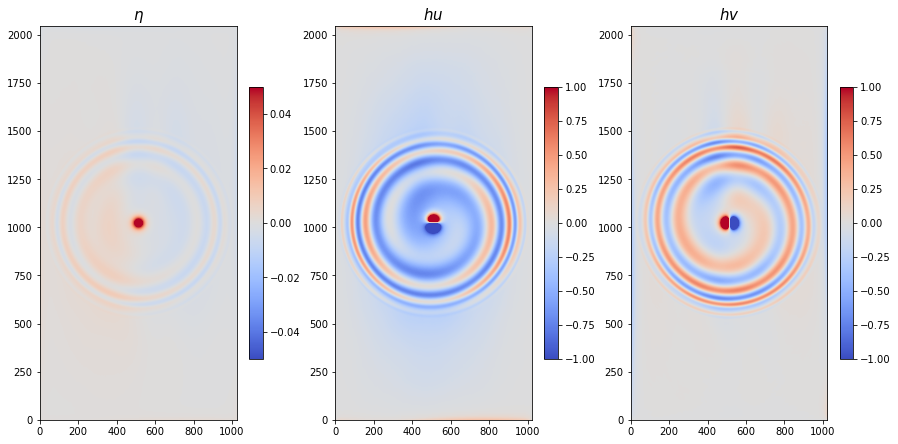

In [ ]:
imshow3(np.average(SL_state, axis=-1))

In [ ]:
def imshow3var(est_var):
    fig, axs = plt.subplots(1,3, figsize=(15,10))
    im = axs[0].imshow(est_var[0], vmin=0.0, vmax=0.00005, cmap="Reds")
    plt.colorbar(im, ax=axs[0], shrink=0.5)
    axs[0].set_title("$\eta$", fontsize=15)

    im = axs[1].imshow(est_var[1], vmin=0, vmax=0.25, cmap="Reds")
    plt.colorbar(im, ax=axs[1], shrink=0.5)
    axs[1].set_title("$hu$", fontsize=15)

    im = axs[2].imshow(est_var[2], vmin=0, vmax=0.25, cmap="Reds")
    plt.colorbar(im, ax=axs[2], shrink=0.5)
    axs[2].set_title("$hv$", fontsize=15)

    # fig.suptitle("ML variance", y=0.9)

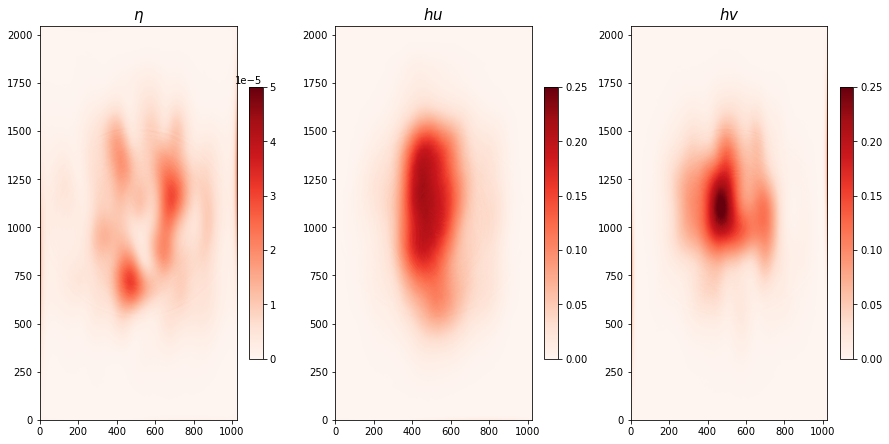

In [ ]:
imshow3var(np.var(SL_state, axis=-1))

In [ ]:
SL_perts = np.random.multivariate_normal(np.zeros(3), np.diag(R), size=SL_Ne)

In [ ]:
obs_idxs = [Hy, Hx]

In [ ]:
X0 = SL_state
X0mean = np.average(X0, axis=-1)

Y0 = SL_state[:,obs_idxs[0],obs_idxs[1]] + SL_perts.T
Y0mean = np.average(Y0, axis=-1)


In [ ]:
SL_XY = (np.tile(GC.flatten(),3)[:,np.newaxis]*1/10*((X0-X0mean[:,:,:,np.newaxis]).reshape(-1,X0.shape[-1]) @ (Y0 - Y0mean[:,np.newaxis]).T)).reshape(X0mean.shape + (3,))

In [ ]:
SL_HXY = SL_XY[:,obs_idxs[0],obs_idxs[1],:]
SL_YY  = SL_HXY + np.diag(R)

SL_K = SL_XY @ np.linalg.inv(SL_YY)

Text(0.5, 0.9, 'Kalman Gain')

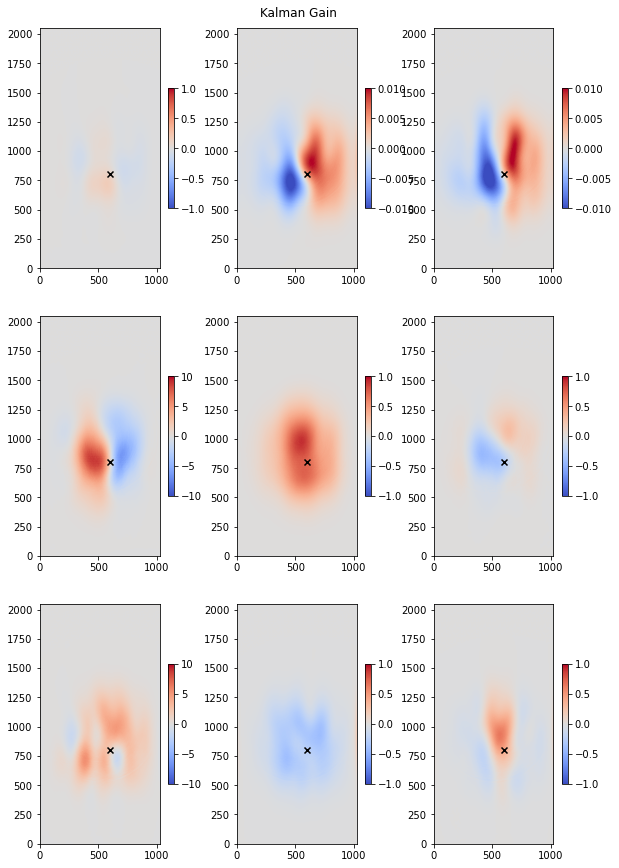

In [ ]:
vlims = [[1, 0.01, 0.01],[10, 1, 1],[10, 1, 1]]

fig, axs = plt.subplots(3,3, figsize=(10,15))
for i in range(3):
    for j in range(3):
        im = axs[i,j].imshow(SL_K[i,:,:,j], vmin=-vlims[i][j],vmax=vlims[i][j], cmap="coolwarm")
        axs[i,j].scatter(Hx, Hy, marker="x", c="black")
        plt.colorbar(im, ax=axs[i,j], shrink=0.5)

fig.suptitle("Kalman Gain", y=0.9)

In [ ]:
SL_state = SL_state + (SL_K @ (obs[:,np.newaxis] - SL_state[:,obs_idxs[0],obs_idxs[1]] - SL_perts.T))


(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

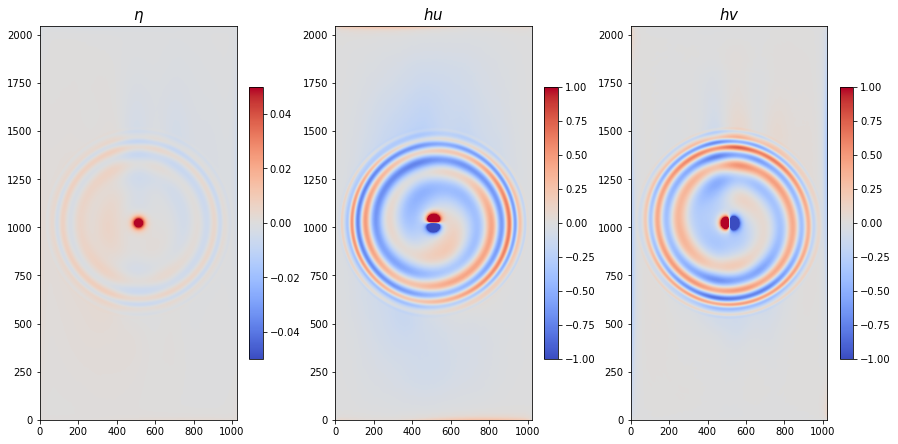

In [ ]:
imshow3(np.average(SL_state, axis=-1))

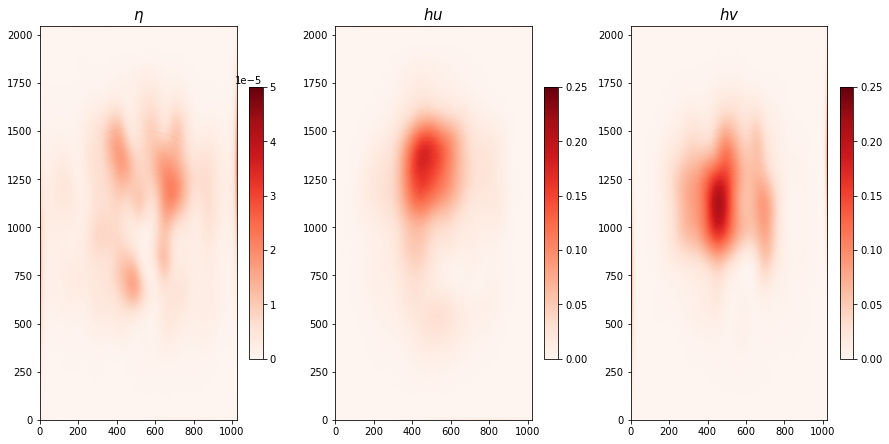

In [ ]:
imshow3var(np.var(SL_state, axis=-1))

In [ ]:
def SL_EnKF(SL_state, r = 2.5*1e7):
    ## Localisation weights
    Xs = np.linspace(0, SL_ensemble[0].nx * SL_ensemble[0].dx, SL_ensemble[0].nx)
    Ys = np.linspace(0, SL_ensemble[0].ny * SL_ensemble[0].dy, SL_ensemble[0].ny)
    X, Y = np.meshgrid(Xs, Ys)

    obs_loc = np.zeros(2)
    obs_loc[0] = X[0,Hx]
    obs_loc[1] = Y[Hy,0]
    dists = np.sqrt((X - obs_loc[0])**2 + (Y - obs_loc[1])**2)

    GC = np.zeros_like(dists)
    for i in range(dists.shape[0]):
        for j in range(dists.shape[1]):
            dist = dists[i,j]
            if dist/r < 1: 
                GC[i,j] = 1 - 5/3*(dist/r)**2 + 5/8*(dist/r)**3 + 1/2*(dist/r)**4 - 1/4*(dist/r)**5
            elif dist/r >= 1 and dist/r < 2:
                GC[i,j] = 4 - 5*(dist/r) + 5/3*(dist/r)**2 + 5/8*(dist/r)**3 -1/2*(dist/r)**4 + 1/12*(dist/r)**5 - 2/(3*(dist/r))
    
    ## Perturbations
    SL_perts = np.random.multivariate_normal(np.zeros(3), np.diag(R), size=SL_Ne)

    ## Analysis
    obs_idxs = [Hy, Hx]

    X0 = SL_state
    X0mean = np.average(X0, axis=-1)

    Y0 = SL_state[:,obs_idxs[0],obs_idxs[1]] + SL_perts.T
    Y0mean = np.average(Y0, axis=-1)

    SL_XY = (np.tile(GC.flatten(),3)[:,np.newaxis]*1/SL_Ne*((X0-X0mean[:,:,:,np.newaxis]).reshape(-1,X0.shape[-1]) @ (Y0 - Y0mean[:,np.newaxis]).T)).reshape(X0mean.shape + (3,))

    SL_HXY = SL_XY[:,obs_idxs[0],obs_idxs[1],:]
    SL_YY  = SL_HXY + np.diag(R)

    SL_K = SL_XY @ np.linalg.inv(SL_YY)

    ## Update
    SL_state = SL_state + (SL_K @ (obs[:,np.newaxis] - SL_state[:,obs_idxs[0],obs_idxs[1]] - SL_perts.T))

    return SL_state
    

In [ ]:
SL_posterior = SL_EnKF(SL_prior)

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

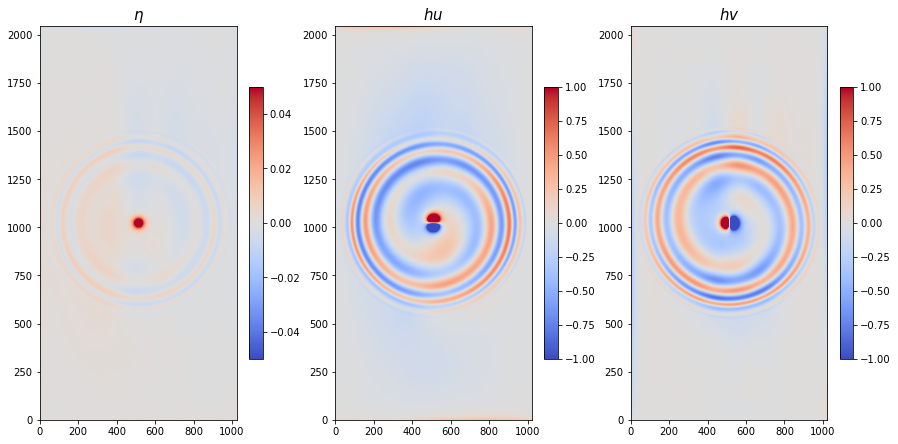

In [ ]:
imshow3(np.average(SL_posterior, axis=-1))

### Multi-level Ensemble

In [ ]:
from utils.RossbyEnsembleInit import * 

In [ ]:
Nes = [100, 75, 50, 25, 10]

In [ ]:
ML_ensemble = initMLensemble(gpu_ctx, ls, Nes, KLSampler, wind_weight, T+30000)

In [ ]:
from gpuocean.ensembles import MultiLevelOceanEnsemble

In [ ]:
from importlib import reload
reload(MultiLevelOceanEnsemble)

<module 'gpuocean.ensembles.MultiLevelOceanEnsemble' from '/home/florianb/havvarsel/gpuocean/src/gpuocean/ensembles/MultiLevelOceanEnsemble.py'>

In [ ]:
MLOceanEnsemble = MultiLevelOceanEnsemble.MultiLevelOceanEnsemble(ML_ensemble)

In [ ]:
MLOceanEnsemble.step(T)

In [ ]:
ML_prior_state = copy.deepcopy(MLOceanEnsemble.download())

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

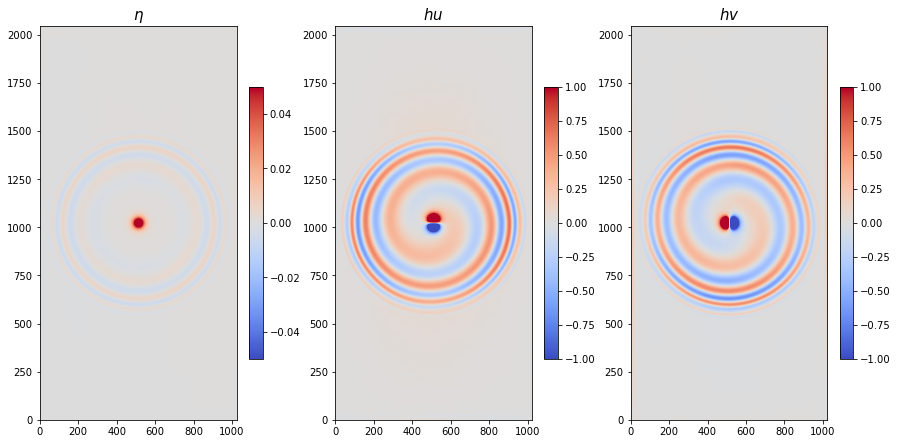

In [ ]:
MLmean = MLOceanEnsemble.estimate(np.mean)
imshow3(MLmean)

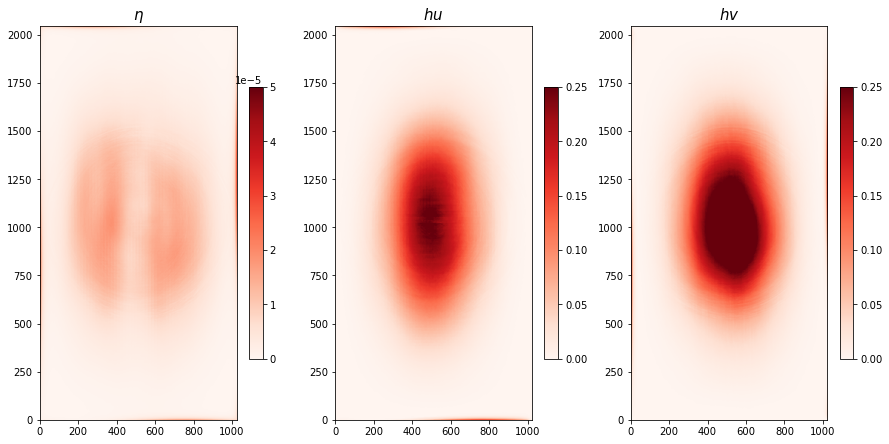

In [ ]:
MLvar = MLOceanEnsemble.estimate(np.var)
imshow3var(MLvar)

### Kalman gain

In [ ]:
from gpuocean.dataassimilation import MLEnKFOcean

In [ ]:
reload(MLEnKFOcean)

<module 'gpuocean.dataassimilation.MLEnKFOcean' from '/home/florianb/havvarsel/gpuocean/src/gpuocean/dataassimilation/MLEnKFOcean.py'>

In [ ]:
MLEnKF = MLEnKFOcean.MLEnKFOcean(MLOceanEnsemble)

In [ ]:
ML_K = MLEnKF.assimilate(MLOceanEnsemble, obs, Hx, Hy, R, r = 2.5*1e7, relax_factor = 1.0)

Text(0.5, 0.9, 'Kalman Gain')

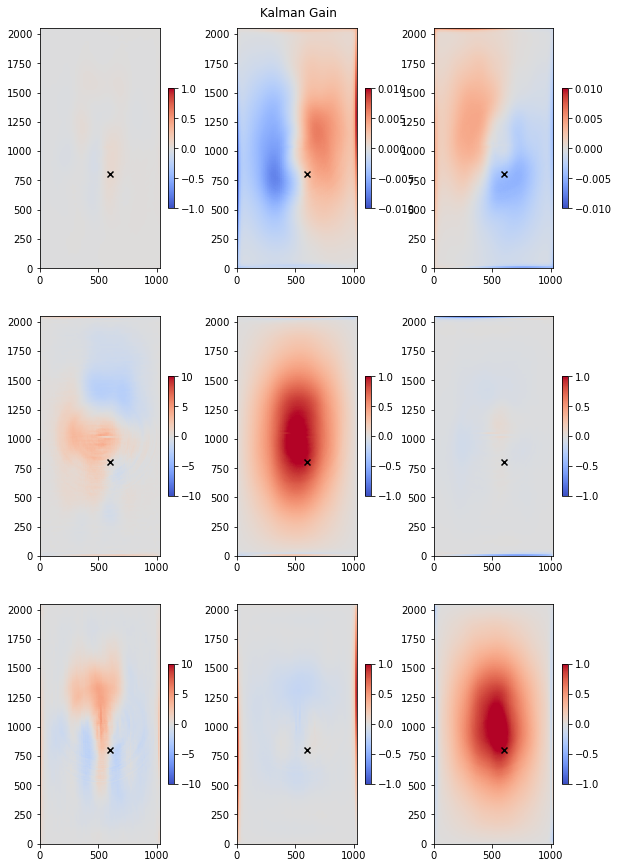

In [ ]:
ML_K_field = ML_K.reshape(MLOceanEnsemble.download()[-1][0].shape[:-1] + (3,))

vlims = [[1, 0.01, 0.01],[10, 1, 1],[10, 1, 1]]

fig, axs = plt.subplots(3,3, figsize=(10,15))
for i in range(3):
    for j in range(3):
        im = axs[i,j].imshow(ML_K_field[i,:,:,j], vmin=-vlims[i][j],vmax=vlims[i][j], cmap="coolwarm")
        axs[i,j].scatter(Hx, Hy, marker="x", c="black")
        plt.colorbar(im, ax=axs[i,j], shrink=0.5)

fig.suptitle("Kalman Gain", y=0.9)

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

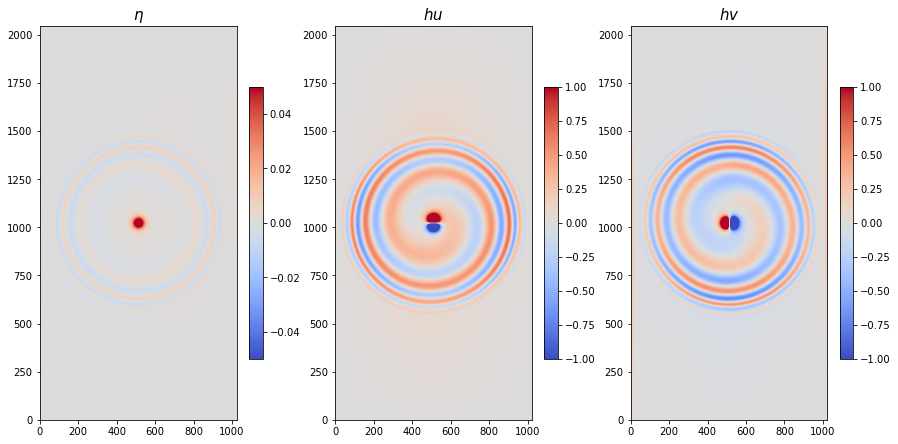

In [ ]:
imshow3(MLOceanEnsemble.estimate(np.mean))

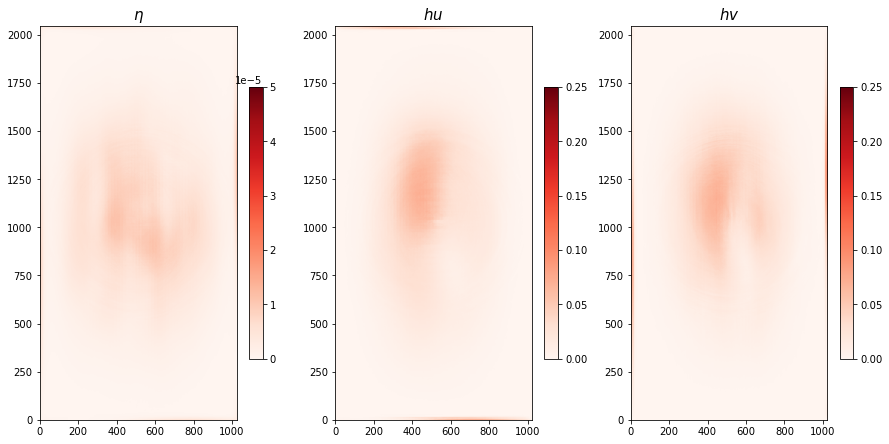

In [ ]:
imshow3var(MLOceanEnsemble.estimate(np.var))